In [41]:
import pandas as pd
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.mllib.linalg import Vector, Vectors
#from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.clustering import LDA, LDAModel
import nltk
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import size
from pyspark.sql.functions import udf, col
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import udf, struct
import pyspark.sql.types as T 
import string
import nltk
from pyspark.sql import Row
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

import os
import sys
from pyspark.sql import SparkSession



In [42]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark =SparkSession.builder.master("local[1]").appName('SparkProject').getOrCreate() 

In [43]:
df = spark.read.json("hdfs://localhost:9000/bigdata/data/tweets.json")

In [44]:
df = df.dropDuplicates(['tweetid'])
#df = df.na.drop()
df = df.filter("content != ''")
#df = df.limit(100)

In [47]:
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- tweetid: long (nullable = true)



In [ ]:
df.
.withColumn("content", regexp_replace($"address", "([0-9]+)". ))
.show()

In [5]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_number(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet

def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet

In [6]:
from pyspark.sql.types import StringType

remove_emoji=udf(remove_emoji)
remove_users=udf(remove_users)
remove_number=udf(remove_number)

df=df.withColumn('content', remove_emoji(df['content']))
df=df.withColumn('content', remove_users(df['content']))
df=df.withColumn('content', remove_number(df['content']))

In [7]:

df = df.withColumn('content', F.regexp_replace('content', r'http\S+', ''))
df = df.withColumn('content', F.regexp_replace('content', '@\w+', ''))
df = df.withColumn('content', F.regexp_replace('content', '#', ''))
df = df.withColumn('content', F.regexp_replace('content', 'RT', ''))
df = df.withColumn('content', F.regexp_replace('content', ':', ''))
df = df.withColumn('content', F.regexp_replace('content', '\n', ''))
df = df.withColumn('content', F.regexp_replace('content', '|', ''))
df = df.withColumn('content', F.regexp_replace('content', '[^\sa-zA-Z0-9]', ''))
df = df.withColumn("content",F.lower('content'))
df = df.withColumn("content",F.rtrim('content'))

df = df.withColumn('Tweet_No', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)

In [8]:
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("content").setOutputCol("tokens")
df = tokenizer.transform(df)
nltk.download('stopwords')
stopwordList = stopwords.words('english')
remover = StopWordsRemover(stopWords=stopwordList)
remover.setInputCol("tokens")
remover.setOutputCol("filtered")

df = remover.transform(df);

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

lemmatization = udf(lemmatization)

df=df.withColumn('tokens', lemmatization(df['filtered']))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bigdata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bigdata/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
df.head(13)

21/12/11 00:24:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(content='electriccar tesla service waits  kw supercharger cheap renewable energy todays car news', tweetid=815528966131957760, Tweet_No=0, tokens='[electriccar, tesla, service, wait, supercharger, cheap, renewable, energy, todays, car, news]', filtered=['electriccar', 'tesla', 'service', 'waits', 'supercharger', 'cheap', 'renewable', 'energy', 'todays', 'car', 'news'], sentiment_polarity=0.4, sentiment_subjectivity=0.7),
 Row(content='electriccar europe electric car sales bmw i  again', tweetid=815570452231942148, Tweet_No=1, tokens='[electriccar, europe, electric, car, sales, bmw]', filtered=['electriccar', 'europe', 'electric', 'car', 'sales', 'bmw'], sentiment_polarity=0.0, sentiment_subjectivity=0.0),
 Row(content='gm bright future for electriccars in gcc', tweetid=815739450198265861, Tweet_No=2, tokens='[bright, future, electriccars, gcc]', filtered=['bright', 'future', 'electriccars', 'gcc'], sentiment_polarity=0.35000000000000003, sentiment_subjectivity=0.46249999999999997)

In [9]:
#sampling data for manual labelling
def get_sample(part=0.17):
    df = df.sample(part)
    df = df.select("tweetid", "content")
    df.coalesce(1).write.option("header", True).csv('sample.csv')

In [10]:
#training and topic modelling

from pyspark.sql.functions import lit
df = df.withColumn("polarity", lit(0))
df = df.withColumn("topic", lit(""))

In [11]:
#extracting tweet sentiment

In [12]:
from textblob import TextBlob

sentiment_polarity = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment_polarity", sentiment_polarity)

sentiment_subjectivity = udf(lambda x: TextBlob(x).sentiment[1])
spark.udf.register("sentiment_subjectivity", sentiment_subjectivity)

<function __main__.<lambda>(x)>

In [13]:
df = df.withColumn('sentiment_polarity',sentiment_polarity('content').cast('double'))


In [14]:
df = df.withColumn('sentiment_subjectivity',sentiment_subjectivity('content').cast('double'))


In [15]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [16]:
#Collecting the data from spark and save to list
words_array = df.select("filtered").rdd.flatMap(lambda x: x).collect()
txt = df.select("content").rdd.flatMap(lambda x: x).collect()

In [17]:
id2word = corpora.Dictionary(words_array)

In [18]:
texts = words_array
corpus = [id2word.doc2bow(text) for text in texts]
bow = corpus

In [19]:
#printing the bag of words
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('car', 1),
  ('cheap', 1),
  ('electriccar', 1),
  ('energy', 1),
  ('news', 1),
  ('renewable', 1),
  ('service', 1),
  ('supercharger', 1),
  ('tesla', 1),
  ('todays', 1),
  ('waits', 1)]]

In [20]:
#function to create and run the guided lda model
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    corp = words_array
    np.random.seed(42) 
    bow = [dictionary.doc2bow(line) for line in corp] 
    with (np.errstate(divide='ignore')):  
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    return model

In [21]:
#function to create the eta for topic modelling
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) 
    for word, topic in priors.items(): 
        keyindex = [index for index,term in etadict.items() if term==word] 
        if (len(keyindex)>0): 
            eta[topic,keyindex[0]] = 1e7 
    eta = np.divide(eta, eta.sum(axis=0)) 
    return eta

In [22]:
topic_labelling = {
    'cost': 0,'value': 0,'worth': 0,'valuation': 0,'premium': 0,'rate': 0,'overprice': 0,'cheap': 0,'discount': 0,'inflation': 0,'pay': 0,'amount': 0,'expense': 0,'expensive': 0,'dollar': 0,'money': 0,'costly': 0,'prise': 0,'priceless': 0,'undervalue': 0,'overvalue': 0,'revaluation': 0,'pennyworth': 0,'economy': 0,'underrate': 0,'underprice': 0,'profit': 0,'estimate':0 ,'fees':0 ,'marginal':0 ,'cash':0 ,'pocket':0 ,'capital':0 ,'dime':0 ,'markup':0 ,'haggle':0 ,'wholesale':0 ,'quotation':0 ,'stipend':0 ,'afford':0 ,'savings':0 ,'save':0,'range':1 ,'anxiety':1 ,'far':1 ,'distance':1 ,'long':1 ,'area':1 ,'long-range':1 ,'short-range':1 ,'travel':1 ,'near':1 ,'mileage':1 ,'afar':1 ,'farther':1 ,'reach':1 ,'remote':1 ,'short':1 ,'stretch':1 ,'haul':1 ,'distant':1 ,'commute':1 ,'extended-range':1,'fuel':2 ,'zero':2 ,'emission':2 ,'das':2 ,'diesel':2 ,'refuel':2 ,'coal':2 ,'oil ':2 ,'charcoal':2 ,'biogas':2 ,'fossil':2 ,'electric':2 ,'ev':2,'eco':3 ,'eco-friendly':3 ,'carbon':3 ,'footprint':3 ,'pollution':3 ,'sustainable':3 ,'renewal':3 ,'power':3 ,'plug':3 ,'green':3 ,'environment':3 ,'earth':3 ,'friendly':3 ,'carbon':3 ,'footprint':3,'batttery':4 ,'cell':4 ,'life':4 ,'charge':4 ,'charger':4 ,'voltage':4 ,'elctrolyte':4 ,'surcharge':4 ,'lithium-ion':4 ,'lithium':4 ,'ion':4 ,'battery cost':4 ,'battery life':4 ,'Fuel cell':4 ,'killowatt':4 ,'hour':4 ,'killowatt-hour':4 ,'regenerative':4 ,'regenerative-braking':4, 'infra':5 ,'infrastructure':5 ,'stations':5 ,'charging':5 ,'plug':5 ,'chademo':5 ,'fast charging':5 ,'supercharger':5 ,'framework':5 ,'structure':5 ,'groundwork':5 ,'support':5
}
eta = create_eta(topic_labelling, id2word, 6)
lda_model = test_eta(eta, id2word, 6,False,False)

In [23]:
data_lemmatized = words_array


In [24]:
data = txt
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Tweet_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tweet']



In [37]:
df_dominant_topic.head(10)

,Tweet_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tweet
0,0,5.0,0.3022,"electric, electricvehicles, electricmobility, ...",electriccar tesla service waits kw supercharg...
1,1,5.0,0.5039,"electric, electricvehicles, electricmobility, ...",electriccar europe electric car sales bmw i a...
2,2,5.0,0.4200,"electric, electricvehicles, electricmobility, ...",gm bright future for electriccars in gcc
3,3,4.0,0.3078,"tesla, make, charge, today, model, range, see,...",hello model goodbye gas forever goev electric...
4,4,5.0,0.5032,"electric, electricvehicles, electricmobility, ...",buyers premium in germany triggers electricca...
5,5,0.0,0.4288,"vehicles, energy, first, drive, news, solar, h...",ford to scrap mexico plant invest in michigan ...
6,6,0.0,0.2486,"vehicles, energy, first, drive, news, solar, h...",us commuters drive lt miles dailyhome power...
7,7,5.0,0.2424,"electric, electricvehicles, electricmobility, ...",and from the east we can see big clouds of mon...
8,8,2.0,0.4509,"evs, emobility, evcharging, charging, amp, bat...",tesla motors has started producing lithiumion ...
9,9,4.0,0.3368,"tesla, make, charge, today, model, range, see,...",electriccar ces biggest event so far was every...


In [25]:
from pyspark.sql.functions import desc

dominant_topic=spark.createDataFrame(df_dominant_topic)
join = df.join(dominant_topic, dominant_topic.Tweet_No == df.Tweet_No, 'left').select(dominant_topic.Tweet_No, dominant_topic.Dominant_Topic,dominant_topic.Tweet,df.sentiment_polarity,df.sentiment_subjectivity)

In [26]:
from pyspark.sql.functions import when

df3 = join.withColumn("Sentiment", when(join.sentiment_polarity > 0, 1).when(join.sentiment_polarity < 0, -1).otherwise(0))


In [27]:
df3 .show()

21/12/10 22:40:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/10 22:40:33 WARN TaskSetManager: Stage 8 contains a task of very large size (21536 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------+--------------------+--------------------+----------------------+---------+
|Tweet_No|Dominant_Topic|               Tweet|  sentiment_polarity|sentiment_subjectivity|Sentiment|
+--------+--------------+--------------------+--------------------+----------------------+---------+
|      26|           4.0|morrisons watford...|                -0.2|                  0.05|       -1|
|      29|           5.0|heres why electri...|                0.05|                   0.2|        1|
|     474|           5.0|electriccar renau...|                 0.0|                   0.0|        0|
|     964|           5.0| vehicles freerid...|-0.16666666666666666|   0.16666666666666666|       -1|
|    1677|           2.0|why even relaunch...|                 0.0|                   0.0|        0|
|    1697|           5.0|interesting glimp...|                0.25|                0.3125|        1|
|    1806|           5.0|new survey about ...|  0.2681818181818182|   0.42727272727272725| 

In [28]:
ll = df3.groupBy("Dominant_Topic").count()
ll = ll.orderBy(col("Dominant_Topic").asc())

sentimentcount = df3.groupBy("Sentiment").count()
sentimentcount = sentimentcount.orderBy(col("Sentiment").asc())

21/12/10 22:41:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/10 22:41:57 WARN TaskSetManager: Stage 25 contains a task of very large size (21536 KiB). The maximum recommended task size is 1000 KiB.


92908


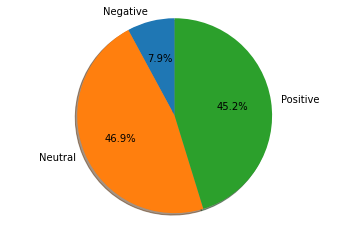

In [30]:
import matplotlib.pyplot as plt

labels = ['Negative','Neutral','Positive']
listValues = list(sentimentcount.select('count').toPandas()['count'])
sum = 0
for item in listValues:
   sum += item
    
print(sum)

listValues = [(number / sum)*100 for number in listValues]

fig1, ax1 = plt.subplots()
ax1.pie(listValues, labels=labels ,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

21/12/10 22:42:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/10 22:42:27 WARN TaskSetManager: Stage 39 contains a task of very large size (21536 KiB). The maximum recommended task size is 1000 KiB.


92908


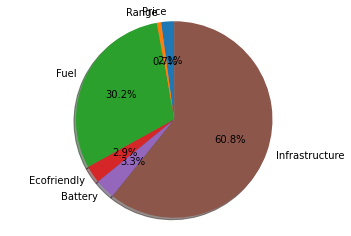

In [31]:


labels = ['Price','Range','Fuel','Ecofriendly','Battery','Infrastructure']
listValues = list(ll.select('count').toPandas()['count'])
sum = 0
for item in listValues:
   sum += item
    
print(sum)

listValues = [(number / sum)*100 for number in listValues]

fig1, ax1 = plt.subplots()
ax1.pie(listValues, labels=labels ,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

21/12/10 22:42:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/10 22:42:33 WARN TaskSetManager: Stage 52 contains a task of very large size (21536 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='Dominant_Topic'>

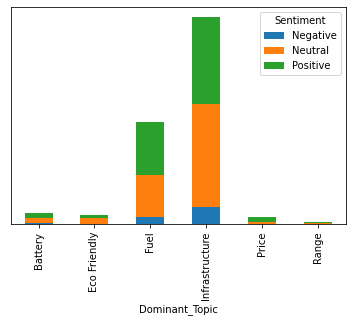

In [32]:
ll = df3.groupBy("Dominant_Topic","Sentiment").count()
ll = ll.orderBy(col("Dominant_Topic").asc())
ll = ll.orderBy(col("Dominant_Topic").asc())
ll = ll.withColumn("Dominant_Topic", when(ll.Dominant_Topic == "0.0","Price").when(ll.Dominant_Topic == "1.0","Range").when(ll.Dominant_Topic == "2.0","Fuel").when(ll.Dominant_Topic == "3.0","Eco Friendly").when(ll.Dominant_Topic == "4.0","Battery").when(ll.Dominant_Topic == "5.0","Infrastructure")
      .otherwise(ll.Dominant_Topic))
ll = ll.withColumn("Sentiment", when(ll.Sentiment == -1,"Negative").when(ll.Sentiment == 0,"Neutral").when(ll.Sentiment == 1,"Positive").otherwise(ll.Sentiment))
pdf = ll.toPandas()
pdf.pivot('Dominant_Topic', 'Sentiment', 'count').plot.bar(stacked=True, yticks=[])

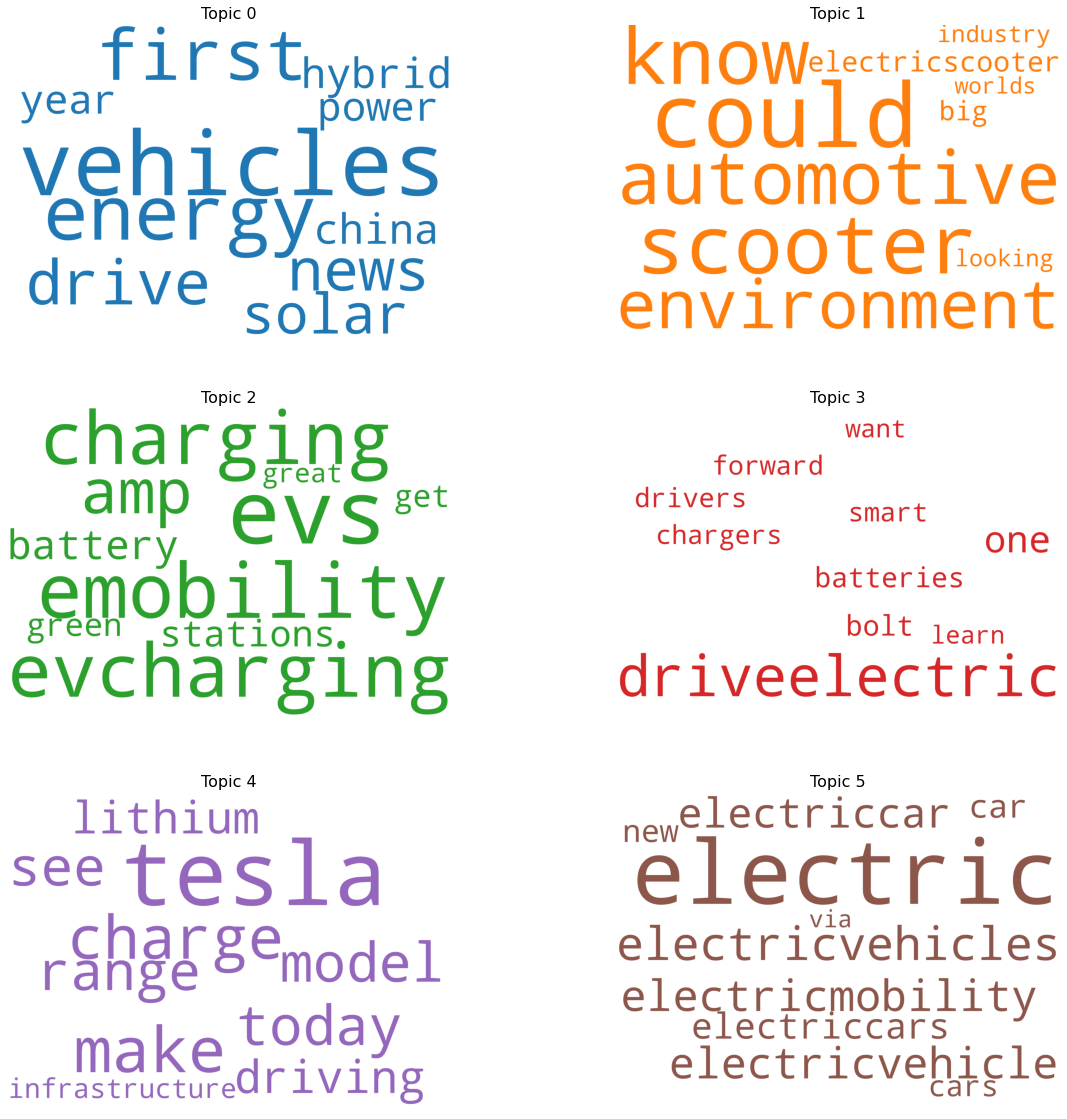

In [33]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwordList,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [34]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/home/bigdata/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.418169 -0.028129       1        1  29.738748
2      0.112521 -0.395066       2        1  24.376578
4      0.071217  0.111029       3        1  13.799551
0      0.081768  0.132336       4        1  12.667776
3      0.082740  0.108307       5        1  11.105786
1      0.069923  0.071522       6        1   8.311561, topic_info=                  Term          Freq         Total Category  logprob  loglift
12            electric  22966.000000  22966.000000  Default  30.0000  30.0000
253                evs  15531.000000  15531.000000  Default  29.0000  29.0000
483      driveelectric   8830.000000   8830.000000  Default  28.0000  28.0000
149   electricvehicles  14939.000000  14939.000000  Default  27.0000  27.0000
979   electricmobility  13137.000000  13137.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
615              boost    461.237889    462.089683   Topic6  -5.1890   2.4857
1441              lets    458.233534    459.082585   Topic6  -5.1955   2.4857
906            leading    457.290791    458.140008   Topic6  -5.1975   2.4857
1063             using    450.786584    451.639024   Topic6  -5.2119   2.4856
530             carbon    501.469020    505.437241   Topic6  -5.1053   2.4796

[279 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
518       5  0.998455     adoption
1077      6  1.068894         afar
1984      4  0.998965       afford
1602      5  0.998974  allelectric
916       3  0.999312         also
...     ...       ...          ...
663       6  0.998919       worlds
823       4  1.000918        worth
864       5  0.998585        would
683       4  0.999714         year
1396      1  0.998981        years

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 5, 1, 4, 2])

/home/bigdata/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bigdata/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bigdata/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bigdata/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [ ]:
#Evaluation Started

In [44]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.21820030274435068
